In [ ]:
!pip install pyarrow==15.0.2 datasets evaluate

In [1]:
import json
import pandas as pd
from tqdm import tqdm
import torch
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, GPT2Tokenizer, GPT2LMHeadModel
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer
import numpy as np
import evaluate

class PerplexityCalculator:
    def __init__(self, m_name='gpt2'):
        # Load GPT-2 tokenizer and model
        self.tokenizer = GPT2Tokenizer.from_pretrained(m_name)
        self.model = GPT2LMHeadModel.from_pretrained(m_name)
        self.model.eval()  # Set model to evaluation mode

    def calculate_perplexity(self, text):
        # Tokenize input text
        encodings = self.tokenizer(text, return_tensors="pt")

        # Prepare inputs for the model
        input_ids = encodings.input_ids

        # Calculate the length of the input
        with torch.no_grad():
            outputs = self.model(input_ids, labels=input_ids)
            loss = outputs.loss  # Cross-entropy loss (negative log likelihood)
        
        # Calculate perplexity
        perplexity = torch.exp(loss)
        return perplexity.item()
    
class ChatGPTClassifier:
    def load_model(self, m_name='Hello-SimpleAI/chatgpt-detector-roberta'):
        # Load the tokenizer and model for chatgpt-detector-roberta
        tokenizer = AutoTokenizer.from_pretrained(m_name)
        model = AutoModelForSequenceClassification.from_pretrained(m_name)
        return tokenizer, model

    def set_model(self, tokenizer, model):
        self.model = model
        self.tokenizer = tokenizer

    def tokenize(self, sent):
        return self.tokenizer.tokenize(sent)

    def calculate(self, text):
        # Tokenize the input text and prepare it for the model
        encodings = self.tokenizer(text, return_tensors="pt")

        with torch.no_grad():
            # Get the model outputs (logits)
            outputs = self.model(**encodings)  
            logits = outputs.logits

        # Apply softmax to get probabilities
        probabilities = torch.softmax(logits, dim=1)

        # Get the predicted class (assuming index 0 is 'AI' and index 1 is 'Human')
        predicted_class = torch.argmax(probabilities, dim=1).item()

        return predicted_class

def predict_all(model, data):
    results = []
    with tqdm(total=len(data)) as pbar:
        if ['calculate_perplexity' in dir(model)][0]:
            for sents in data:
                res = []
                for s in sents:
                    perplexity_score = model.calculate_perplexity(s)
                    res.append(perplexity_score)
                results.append(res)
                pbar.update(1)
        else:
            for sents in data:
                res = []
                for s in sents:
                    predicted_class = model.calculate(s)
                    # a sanity check
                    _ = classify_output(predicted_class)
                    res.append(predicted_class)
                results.append(res)
                pbar.update(1)
    return results

def classify_output(predicted_class):
    if predicted_class == 0:
        return "machine"
    elif predicted_class == 1:
        return "human"
    else:
        print("something went wrong")
        return "unknown"

def get_scores(y, y_hat):
    print("kappa:\t", cohen_kappa_score(flatten(y), flatten(y_hat)))
    print("f1-0:\t", f1_score(y_true=flatten(y), y_pred=flatten(y_hat), 
                                average='binary', pos_label=0))
    print("f1-1:\t", f1_score(y_true=flatten(y), y_pred=flatten(y_hat), 
                                average='binary', pos_label=1))

def predict_article_labels(article):
    # Assign prediction labels for the test set

    sentences = article['sent']
    predicted_labels = ['machine' if label == 1 else 'human' for label in article['y_hat']]
    answer_format = {"id": article['id'], "sent_and_label": [[sent, pred] for sent, pred in zip(sentences, predicted_labels)], "domain": article['domain']}
    return answer_format

def extract_sentences_and_labels(df):
    # Extract sentences and labels

    sentences = []
    labels = []
    for _, row in df.iterrows():
        sent_and_label = row['sent_and_label']
        sentences.append([sentence for sentence, _ in sent_and_label])
        labels.append([1 if label == 'machine' else 0 for _, label in sent_and_label])
    return sentences, labels

def flatten(xss):
    return [x for xs in xss for x in xs]

# train_file_path = 'train.json'
# test_file_path = 'phase1_test_without_labels.json'

train_file_path = 'data/train.json'
test_file_path = 'data/phase1_test_without_labels.json'
output_file_path = 'output.json'

train_val_df = pd.read_json(train_file_path)
test_df = pd.read_json(test_file_path)

# print(train_val_df['domain'].value_counts())
# print(test_df['domain'].value_counts())
train_sentences, train_labels = extract_sentences_and_labels(train_val_df)
train_val_df['sents'] = train_sentences
train_val_df['class'] = train_labels

# X_train, X_val, y_train, y_val = train_test_split(train_val_df['sents'], train_val_df['class'], 
#                                                   stratify=train_val_df['domain'], 
#                                                   test_size=0.3, shuffle=True, random_state=42)
# train_val_df['split'] = None

# train_mask = [True if id in X_train.index else False for id in train_val_df['id']]
# train_val_df.loc[train_mask, 'split'] = 'train'

# val_mask = [True if id in X_val.index else False for id in train_val_df['id']]
# train_val_df.loc[val_mask, 'split'] = 'valid'

# stratify in domain
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, train_size=0.9, random_state=42).split(
    train_val_df['sents'], train_val_df['domain'])

train_index, test_index  = list(sss)[0]
# train_val_df.loc[train_index, 'domain'].value_counts()
# train_val_df.loc[test_index, 'domain'].value_counts()

unnested_train = pd.DataFrame({
    'sents': train_val_df.loc[train_index, 'sents'].explode().values,
    'class': train_val_df.loc[train_index, 'class'].explode().values
}).reset_index(drop=True)

unnested_val = pd.DataFrame({
    'sents': train_val_df.loc[test_index, 'sents'].explode().values,
    'class': train_val_df.loc[test_index, 'class'].explode().values
}).reset_index(drop=True)

tds = Dataset.from_pandas(unnested_train)
vds = Dataset.from_pandas(unnested_val)

ds = DatasetDict()
ds['train'] = tds
ds['validation'] = vds

print(ds)

/opt/homebrew/anaconda3/envs/p11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['sents', 'class'],
        num_rows: 190933
    })
    validation: Dataset({
        features: ['sents', 'class'],
        num_rows: 21861
    })
})


In [15]:

# Define two binary arrays (ground truth and predicted)
y_true = [0, 1, 0, 1, 1, 0, 1, 1]
y_pred = [0, 1, 0, 0, 1, 1, 1, 1]

cohen_kappa_score(y_true, y_pred)

0.4666666666666667

In [18]:




def preprocess_function(examples):
    return tokenizer(examples["sents"], truncation=True)


accuracy = evaluate.load("accuracy")
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
tokenized_data = ds.map(preprocess_function, batched=True)


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


id2label = {0: "human", 1: "machine"}
label2id = {"human": 0, "machine": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/homebrew/anaconda3/envs/p11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 21861/21861 [00:00<00:00, 39373.59 examples/s]


: 

In [4]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="stevhliu/my_awesome_model")
classifier(text)

class
1    126015
0     64918
Name: count, dtype: int64

Map: 100%|██████████| 21861/21861 [00:00<00:00, 40087.93 examples/s]


In [8]:
import evaluate

accuracy = evaluate.load("accuracy")

ModuleNotFoundError: No module named 'evaluate'

In [9]:
!pip install 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/a2/e7/cbca9e2d2590eb9b5aa8f7ebabe1beb1498f9462d2ecede5c9fd9735faaf/evaluate-0.4.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.3 MB/s eta 0:00:00eta 0:00:01


In [17]:
detector = ChatGPTClassifier()
tokenizer, model = detector.load_model()
detector.set_model(tokenizer, model)

y_hat = predict_all(detector, train_val_df['sents'][:10])
get_scores(train_val_df['class'][:10], y_hat)

#perplexity_calculator = PerplexityCalculator("EleutherAI/gpt-j-6B")
perplexity_calculator = PerplexityCalculator("gpt2")
p_gpt2_train = predict_all(perplexity_calculator, train_val_df['sents'][:10])

train_val_df['class_hc3'] = y_hat
train_val_df['p_gpt2'] = p_gpt2_train

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


kappa:	 0.2086747951229263
f1-0:	 0.463768115942029
f1-1:	 0.7448275862068966


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


## Testset infer

In [43]:
# infer on test and save test results

test_classes = predict_all(detector, test_df['sent'])
test_df['y_hat'] = test_classes

answer_list = []
for index, row in test_df.iterrows():
    answer_format = predict_article_labels(row)
    answer_list.append(answer_format)

with open(output_file_path, 'w') as f:
    json.dump(answer_list, f, ensure_ascii=False, indent=4)

100%|██████████| 500/500 [02:18<00:00,  3.61it/s]


<Axes: ylabel='Frequency'>

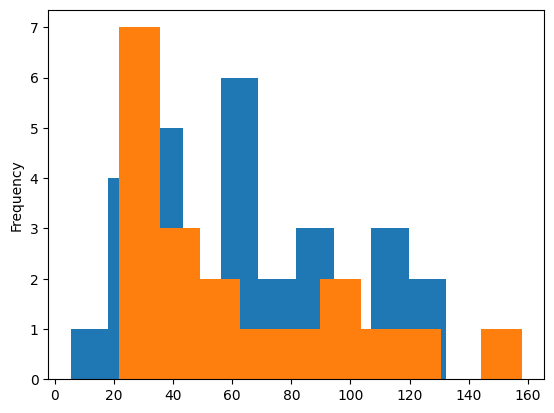

In [60]:
gpt_2_res = pd.DataFrame({'scores':gpt_2_scores})
gpt_2_res['y'] = train_labels 
gpt_2_res.loc[gpt_2_res['y'] == 1, 'scores'].plot(kind='hist')
gpt_2_res.loc[gpt_2_res['y'] == 0, 'scores'].plot(kind='hist')